# MedInfo 2019 Practical 4
****

In this practical session you will explore some of the concepts discussed in the machine learning lecture.

Machine learning (ML) is being increasingly used but care does need to be taken when implementing such models. All too often ML models are not developed and tested to the same rigor as standard CPMs. The TRIPOD guidelines and PROGRESS papers discuss the reporting guidelines and how to develop and validate a CPM and the group behind these are currently extending these to include ML approaches.

Machine learning approaches are data hungry and do not perform well on imbalanced data. Therefore, machine learning approaches are not the method of choice for developing a prediction model using our data (as you will see in the practical). However, for consistency we will use the same data and implement random forests to predict a cardiovascular event within 2 years (the same outcome used in practical 1).  

Although ML is not the most appropriate approach to use for our problem, ML can be very effective. In particular for text or image analysis.



### Lets begin

First lets load the packages we will be using in the practical

In [1]:
library(randomForest)
library(mlbench)
library(caret)
library(pROC)

Warning message:
"package 'randomForest' was built under R version 3.6.1"randomForest 4.6-14
Type rfNews() to see new features/changes/bug fixes.
Warning message:
"package 'mlbench' was built under R version 3.6.1"Warning message:
"package 'caret' was built under R version 3.6.1"Loading required package: lattice
Loading required package: ggplot2
Registered S3 methods overwritten by 'ggplot2':
  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang

Attaching package: 'ggplot2'

The following object is masked from 'package:randomForest':

    margin

Warning message:
"package 'pROC' was built under R version 3.6.1"Type 'citation("pROC")' for a citation.

Attaching package: 'pROC'

The following objects are masked from 'package:stats':

    cov, smooth, var



## Part 1
Load the data (smart) as we did in practical 1. The "Data/SMARTs_medinfo_P2-4.rds" file is the same data as before but albumin is already a categorical variable and the SBP variable has already been generated

Begin by loading the data

In [20]:
smart <- readRDS("SMARTs_medinfo_P2-4.rds")
smart1 <- subset(smart, select = c(outcome, TEVENT, EVENT, SEX, AGE, SBP, alcohol, CHOLO, BMIO, DIABETES, CARDIAC, SMOKING, AAA))
smart1 <- na.omit(smart1)
smart <- smart[,-1:-2]
smart <- na.omit(smart)
smart$outcome <- as.factor(as.character(smart$outcome))

In [21]:
table(smart$outcome)


   0    1 
3340  185 

In [22]:
head(smart)

,SEX,AGE,DIABETES,CEREBRAL,CARDIAC,AAA,PERIPH,STENOSIS,LENGTHO,WEIGHTO,BMIO,CHOLO,albumin,SMOKING,packyrs,alcohol,outcome,SBP
1,Male,71,1,0,1,0,1,0,1.70,69,23.88,6.0,1,Former,22.5,Current,0,185
2,Female,46,0,0,0,0,1,0,1.72,71,24.00,4.0,1,Never,0.0,Never,0,135
3,Male,59,0,0,1,0,1,0,1.77,82,26.17,4.9,1,Former,33.3,Current,0,149
5,Male,57,0,0,1,0,1,0,1.90,107,29.64,5.2,1,Former,53.2,Current,0,177
6,Female,52,1,0,0,0,1,0,1.73,103,34.41,4.6,3,Former,54.6,Never,0,164
7,Male,66,0,1,0,1,0,1,1.65,66,24.24,5.8,1,Former,72.8,Current,0,166


## Part 2
Split the data  

As discussed in the lectures, we can split our data into two parts. A 'training' set, for model development, and a 'test' set, for validation. This is often not advised as you are 'throwing away' data, however, this is still standard practice for ML methods. In this practical we will split the data because it is easier to illustrate some of the concepts we will discuss, but we do advise that k-fold cross-validation (or bootstrapping) be undertaken.  

We will split the data using 75% for development and 25% for validation.

In [23]:
# split data
set.seed(123)
train_ind <- sample(seq_len(nrow(smart)), size = floor(0.75 * nrow(smart))) #use 75% of the data for training and the remaining 25% for testing
TrainData <- smart[train_ind, ]
TestData <- smart[-train_ind, ]

## Part 3
Random forest.

Lets first run a random forest with one predictor (AGE)

In [24]:
set.seed(123)
modfit <- randomForest(outcome ~ AGE, data=TrainData)
modfit


Call:
 randomForest(formula = outcome ~ AGE, data = TrainData) 
               Type of random forest: classification
                     Number of trees: 500
No. of variables tried at each split: 1

        OOB estimate of  error rate: 5.52%
Confusion matrix:
     0 1  class.error
0 2497 2 0.0008003201
1  144 0 1.0000000000

The default is to fit 500 trees.  
Once we have fitted our model we can use the 'predict()' function to as we have in the other preactical to obtain the models predictions in the validation data set.

In [25]:
pred <- predict(modfit, TestData)
table(pred)
table(pred, TestData$outcome)

pred
  0   1 
882   0 

    
pred   0   1
   0 841  41
   1   0   0

This model predicts no individuals to have the event.  
From the model we can obtain each individuals probability of having the outcome. 

In [26]:
pred <- predict(modfit, TestData, type= "prob")
summary(pred[,2])
pred1 <- ifelse(pred[,2]>0.1,1,0)
table(pred1)

     Min.   1st Qu.    Median      Mean   3rd Qu.      Max. 
0.0000000 0.0000000 0.0000000 0.0002608 0.0000000 0.2020000 

pred1
  0   1 
881   1 

We can see that the maximum probability assigned to an individual was 0.2 (20%). Therefore, 0 individuals were above the 0.5 threshold fo rthe model to predict them as having the outcome. Even if we change this threshold to 0.1, the model still only predicts 1 individual to have the outcome in the validation data.  

Lets see if we can improve our model by including more variables of interest...

In [32]:
set.seed(123)
modfit <- randomForest(outcome ~ SEX + AGE + SBP + DIABETES + alcohol + BMIO + CARDIAC + SMOKING + AAA,
                data=TrainData, importance=TRUE)
modfit


Call:
 randomForest(formula = outcome ~ SEX + AGE + SBP + DIABETES +      alcohol + BMIO + CARDIAC + SMOKING + AAA, data = TrainData,      importance = TRUE) 
               Type of random forest: classification
                     Number of trees: 500
No. of variables tried at each split: 3

        OOB estimate of  error rate: 5.56%
Confusion matrix:
     0 1 class.error
0 2496 3  0.00120048
1  144 0  1.00000000

In [33]:
pred <- predict(modfit, TestData)
table(pred)

pred
  0   1 
880   2 

This model now predicts 2 individuals to have the event and so including all the predictors has had little improvement. This is likely due to class imbalance. As mentioned before, random forests do not preform well when there are not even numbers of individuals in each class. By classifying all individuals to the 0 outcome, the model beleives it has good accuracy. It is 95% accurate at predicting by doing this.  

Even if we validate this model using discrimination the model can appear to perform well.

Setting levels: control = 0, case = 1
Setting direction: controls < cases



Call:
roc.formula(formula = TestData$outcome ~ pred[, 2], ci = TRUE)

Data: pred[, 2] in 841 controls (TestData$outcome 0) < 41 cases (TestData$outcome 1).
Area under the curve: 0.6242
95% CI: 0.5387-0.7096 (DeLong)

Setting levels: control = 0, case = 1
Setting direction: controls < cases


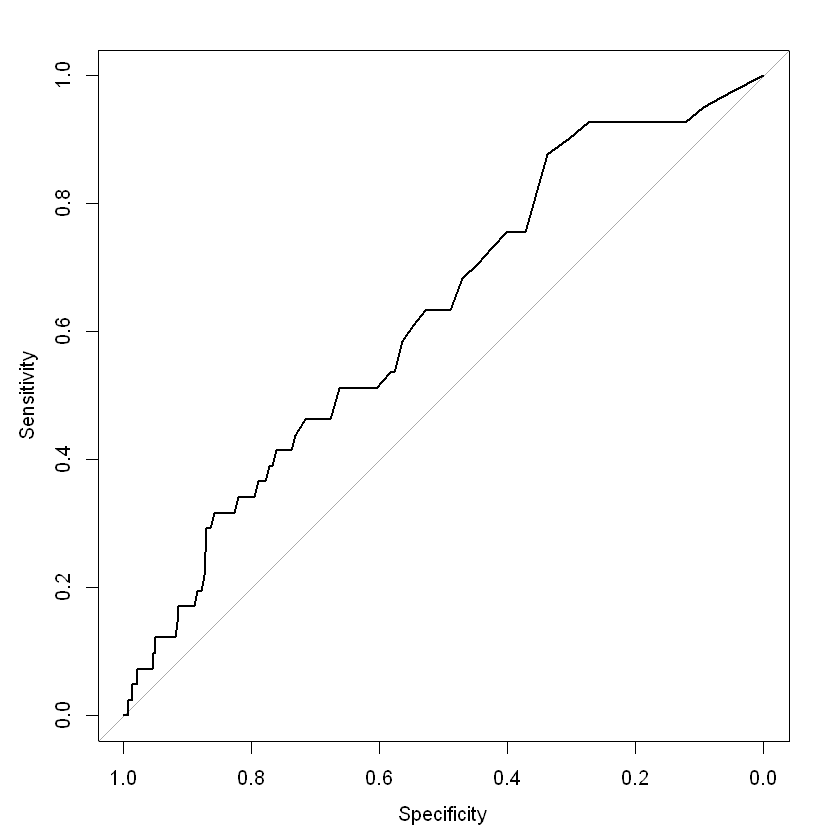

In [34]:
pred <- predict(modfit, TestData, type="prob")
c1 <- roc(TestData$outcome~pred[,2],ci=TRUE)
c1
plot(roc(TestData$outcome,pred[,2]))

This model has a c-statistic of 0.624 and thus has reasonable discrimination. ML methods often also use precision and recall when describing the model validation.

Recall represents the proportion of events that were correctly identified and precision is the proportion of individuals predicted to have the outcome that were correct. Both of these should be checked when examining a model but improvment in one typically reduces the other. 

Here the precision and recall are both 0% eventhough the c-statistic is 0.624.

## Part 4 Imbalanced data

There are 2 ways we can attempt to overcome imbalanced data in random forests.
1. Cost-sensitive learning
2. Sampling

The cost-sensitive approach is to assign different weights to different classes. So if the minority class is assigned a higher weight and thus higher misclassification cost, then that can help reduce its biasness towards the majority class. You can use the 'classwt' opition in R's randomForest package to assign weights to each class.

The sampling apprach can be undertaken in a umber of ways, including oversampling the minority class or undersampling the majority class. Here, we will show an example of undersampling the majority class.

Lets begin with the cost-sensitive approach. Approximatly 10% of individuals have the outcome and so we give this class 90% of the weight in the random forest.

In [81]:
set.seed(123)
modfitw <- randomForest(outcome ~ SEX + AGE + SBP + DIABETES + alcohol + BMIO + CARDIAC + SMOKING + AAA,
                data=TrainData, importance=TRUE,classwt= c(10,90))
#modfitw

There are 144 events in the training data so lets sample 144 from each class and run the model. We do this using the 'sampsize' option.

In [82]:
set.seed(123)
modfits <- randomForest(outcome ~ SEX + AGE + SBP + DIABETES + alcohol + BMIO + CARDIAC + SMOKING + AAA,
                data=TrainData, importance=TRUE,sampsize = c(144,144))
#modfits

In [83]:
predw <- predict(modfitw, TestData)
preds <- predict(modfits, TestData)
table(predw)
table(preds)
#table(pred, TestData$outcome)

predw
  0   1 
880   2 

preds
  0   1 
699 183 

In this example, the cost-sensitive approach looks to still be underpredicting the outcome and the sampling approach appears to be overpredicting the outcome.

Lets check precision recall 

In [84]:
table(predw, TestData$outcome)
table(preds, TestData$outcome)

     
predw   0   1
    0 839  41
    1   2   0

     
preds   0   1
    0 672  27
    1 169  14

**Can you compute the precision and recall for the cost model? What do you conclude from this?**

In [ ]:
#

Although the sampling model has the best precision and recall, the c-statistic is worse than the model without adjusting for imbalance. In fact, the sampling approach is about as effective as flipping a coin and has low discrimination.

3     7    15    23    47    51 
0.156 0.098 0.168 0.128 0.046 0.026

Setting levels: control = 0, case = 1
Setting direction: controls < cases



Call:
roc.formula(formula = TestData$outcome ~ preds[, 2], ci = TRUE)

Data: preds[, 2] in 841 controls (TestData$outcome 0) < 41 cases (TestData$outcome 1).
Area under the curve: 0.5459
95% CI: 0.4642-0.6276 (DeLong)

Setting levels: control = 0, case = 1
Setting direction: controls < cases


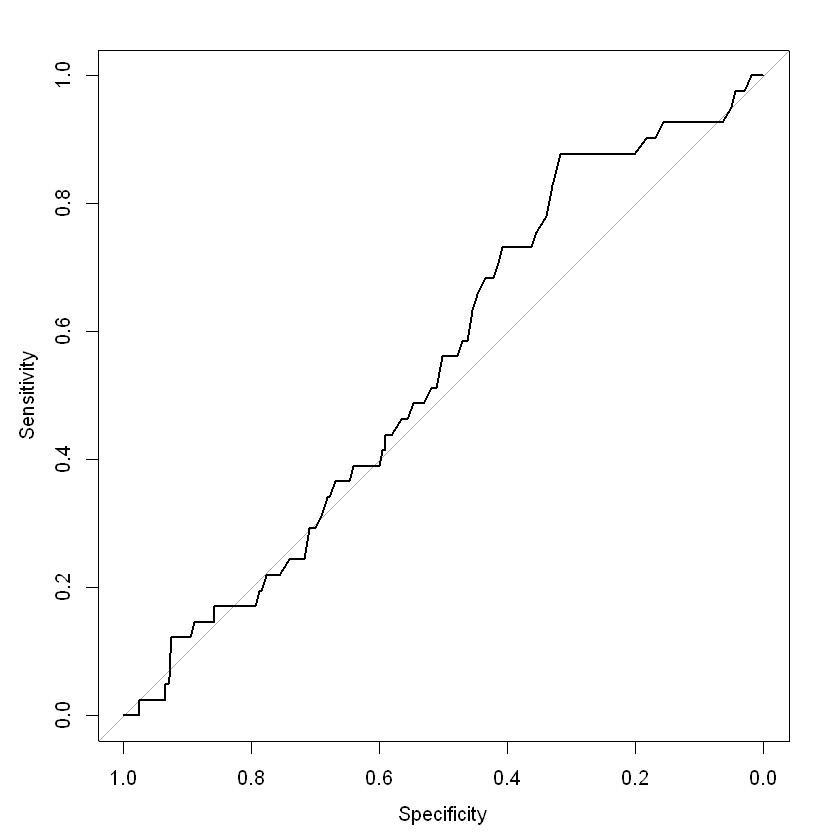

In [92]:
preds <- predict(modfit, TestData, type="prob")
head(preds[,2])
c1 <- roc(TestData$outcome~preds[,2],ci=TRUE)
c1
plot(roc(TestData$outcome,preds[,2]))

## Part 5 Importance

In the regression and survival models, we use the model coefficients to asses if a predictor is associated with the outcome and an important predictor. In random forests we use variable importance. We can calculate the variable importance of a random forest model as follows,

,0,1,MeanDecreaseAccuracy,MeanDecreaseGini
SEX,4.281440,-1.6846860,4.188269,3.912485
AGE,13.433866,6.1849056,14.096683,33.907202
SBP,16.103430,-0.5405472,16.050202,34.484075
DIABETES,6.989353,5.3461875,7.605150,5.186054
alcohol,1.717402,-1.3748287,1.582875,6.872509
BMIO,6.904274,-1.0540875,6.698545,34.974962
CARDIAC,3.176225,0.9664831,3.314295,4.782979
SMOKING,4.350813,-0.6907835,4.260778,6.750771
AAA,5.197142,5.5139374,5.805171,4.613339


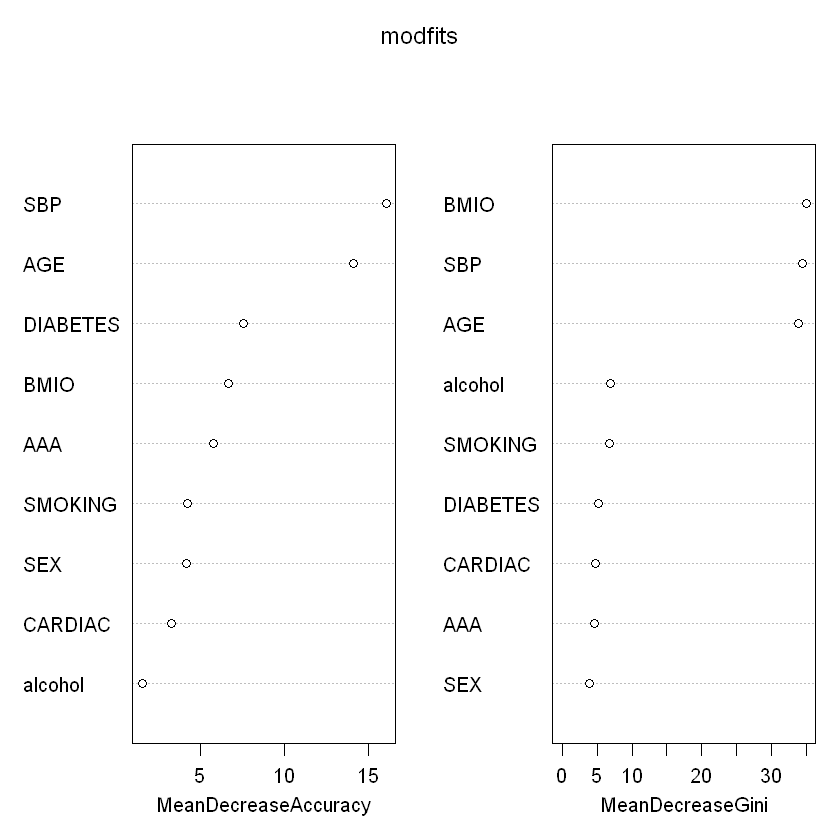

In [93]:
importance(modfits)
varImpPlot(modfits)

Both 'MeanDecreaseAccuracy' and 'MeanDecreaseGini' are measures of variable importance. Variables with large values are considered more 'important'. SBP, AGE and BMIO are chosen as important variables in both measures but DIABETES is only important in the 'MeanDecreaseAccuracy'.

The absolute values of variable importance cannot be compared accros models. The 'MeanDecreaseAccuracy' for age is 14 but applying the model to another data set could result in the value decreasing but it being the most important feature, it is the ranking and the relative importance that can be compared in this scenario. 

Note - Although it is not common, variable importance can be used as a way to determine which variables should be included in a regression model.

## Part 6 Hyperparameter optimisation

So far we have used R to implement a random forest model on our data but have been using many of the package defaults. For example, the default is to use 500 trees. Also, at each node/split the default is to select and try n variables at each split, where n is the square root of the total number of predictors used in the model. Many of these can impact the model performance and so we should attempt to optimise our model. In machine learning, hyperparameter optimization (or tuning) is the problem of choosing a set of optimal hyperparameters for a learning algorithm, where a hyperparameter is a parameter used to control the learning process. 

The traditional way of performing hyperparameter optimization has been grid search, or a parameter sweep, which is simply an exhaustive searching through a manually specified subset of the hyperparameter space of a learning algorithm. A grid search algorithm must be guided by some performance metric, typically measured by cross-validation on the training set or evaluation on a held-out validation set.

Here we will perform a grid search cross-validation to choose the number of variables used at each node/split. We will use 10-fold cross-validation repeated 3 times and test for the optimum number of variable as each split between 1 and 5. Both 'accuracy' and 'kappa' are options to select the parameters and below you will see that both options choose the same hyperparameter values. *note - these will not always choose the same model*

Below is the code to conduct this in the training data. *note - the cross validation does not use the validaion dataset*

Random Forest 

2643 samples
   5 predictor
   2 classes: '0', '1' 

No pre-processing
Resampling: Cross-Validated (10 fold, repeated 3 times) 
Summary of sample sizes: 2379, 2379, 2378, 2379, 2379, 2379, ... 
Resampling results across tuning parameters:

  mtry  Accuracy   Kappa        
  1     0.9447621   0.0000000000
  2     0.9442580  -0.0009508638
  3     0.9427438  -0.0037312504
  4     0.9416080  -0.0057621982
  5     0.9413564  -0.0024914752

Accuracy was used to select the optimal model using the largest value.
The final value used for the model was mtry = 1.


pred
  0   1 
882   0 

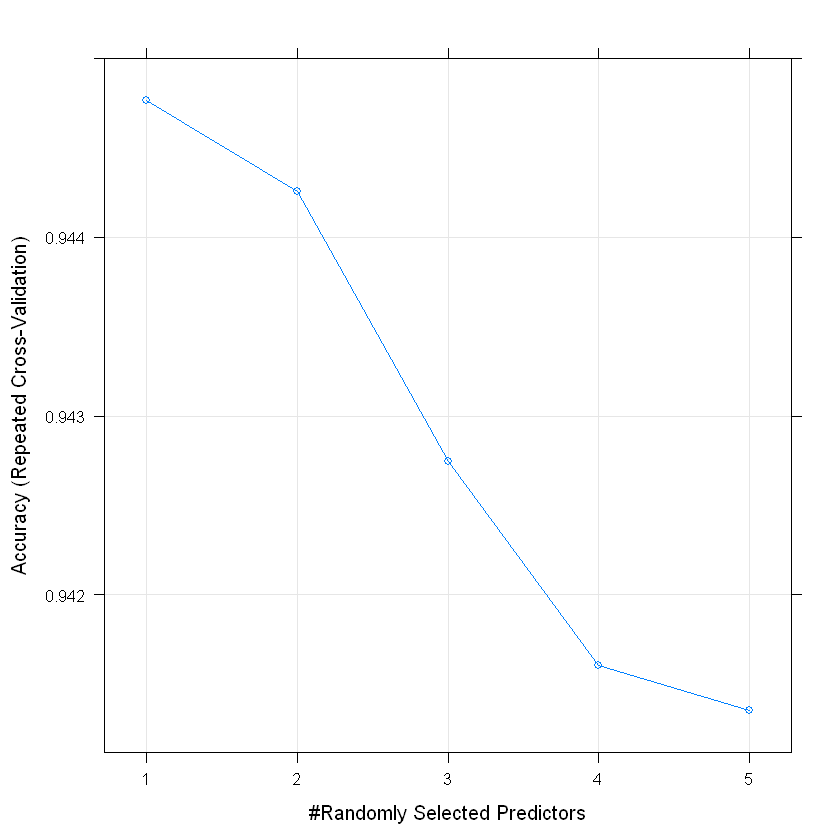

In [128]:
control <- trainControl(method="repeatedcv", number=10, repeats=3, search="grid")
set.seed(123)
tunegrid <- expand.grid(.mtry=c(1:5))
rf_gridsearch <- train(outcome~SEX + AGE + SBP + DIABETES + alcohol + BMIO + CARDIAC + SMOKING + AAA, data=TrainData, method="rf", metric="Accuracy", tuneGrid=tunegrid, trControl=control)
print(rf_gridsearch)
plot(rf_gridsearch)
pred <- predict(rf_gridsearch, TestData)
table(pred)

Random Forest 

2643 samples
   5 predictor
   2 classes: '0', '1' 

No pre-processing
Resampling: Cross-Validated (10 fold, repeated 3 times) 
Summary of sample sizes: 2379, 2379, 2378, 2379, 2379, 2379, ... 
Resampling results across tuning parameters:

  mtry  Accuracy   Kappa        
  1     0.9447621   0.0000000000
  2     0.9442580  -0.0009508638
  3     0.9427438  -0.0037312504
  4     0.9416080  -0.0057621982
  5     0.9413564  -0.0024914752

Kappa was used to select the optimal model using the largest value.
The final value used for the model was mtry = 1.


pred
  0   1 
882   0 

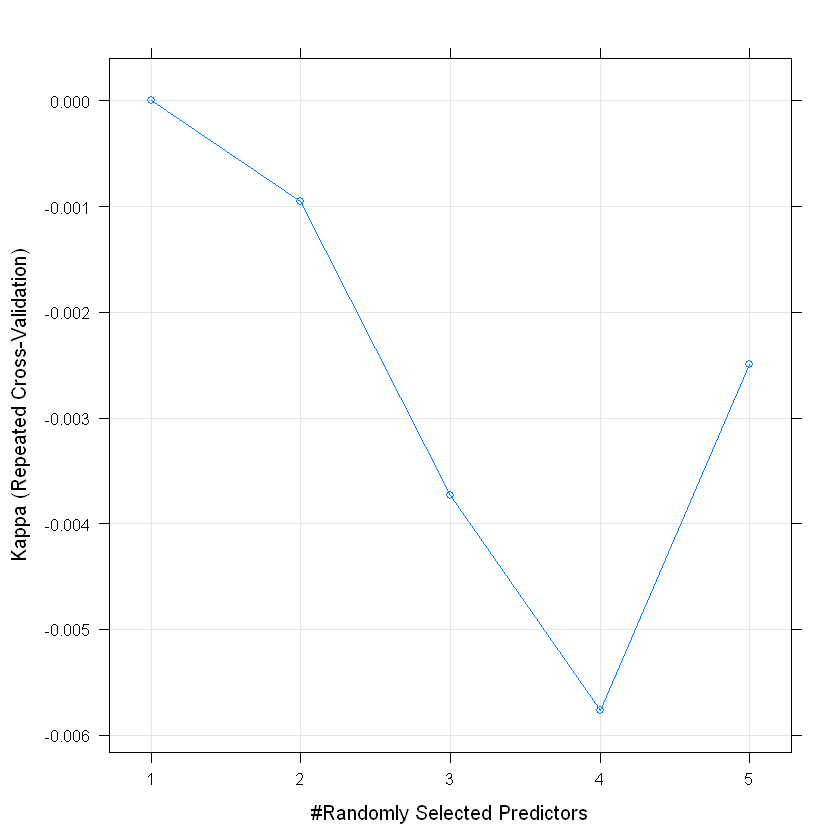

In [127]:
control <- trainControl(method="repeatedcv", number=10, repeats=3, search="grid")
set.seed(123)
tunegrid <- expand.grid(.mtry=c(1:5))
rf_gridsearch <- train(outcome~ SEX + AGE + SBP + DIABETES + alcohol + BMIO + CARDIAC + SMOKING + AAA, data=TrainData, method="rf", metric="Kappa", tuneGrid=tunegrid, trControl=control)
print(rf_gridsearch)
plot(rf_gridsearch)
pred <- predict(rf_gridsearch, TestData)
table(pred)

Both of the above choose the hyperparameter value to be 1 (mtry=1). 

Here we have only considered 1 hyperparameter but if you are tuning more than one you should not conduct each tuning seperatly but together in the same grid search.

**Note**

This practical was to show you how to perform random forest models using R and to illustrate some of the challenges around machine learning.
This was not a tutorial on how to build a prediction model using machine learning.
When developing a model you need to decide which is the most appropriate model for your setting and the data you are using. If you chose a ML approach to build a prediction model the same procedure and model development should be applied as though you are building a CPM using regression modelling. The TRIPOD and PROGRESS papers should always be used.
  